# Seasonality analysis

In [1]:
import os
import datetime as dt
import pickle


import pandas as pd
from pandas_datareader import data as pdr

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec

import seaborn as sns

import yfinance as yf

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

from IPython.display import display, Markdown

import requests_cache
from requests import Session
from requests_cache import CacheMixin, SQLiteCache
from requests_ratelimiter import LimiterMixin, MemoryQueueBucket
from pyrate_limiter import Duration, RequestRate, Limiter



class CachedLimiterSession(CacheMixin, LimiterMixin, Session):
    pass





# select the symbol to analyze

# symbol = '2B7K.DE'    # iShares MSCI World SRI UCITS ETF EUR (Acc)
# symbol = 'EUNL.DE'    # iShares Core MSCI World UCITS ETF USD (Acc)
# symbol = 'EURUSD=X'   # USD/EUR
# symbol = 'GBPUSD=X'   # GBP/USD
# symbol = 'AUDUSD=X'   # AUD/USD
# symbol = '^ATX'       # Austrian Traded Index in EUR
# symbol = 'ALV.DE'     # Allianz SE
# symbol = 'ADS.DE'     # adidas AG
# symbol = 'EBAY'       # eBay Inc.
# symbol = 'AXP'        # American Express Company
# symbol = 'BTC-USD'    # Bitcoin USD
# symbol = 'ETH-USD'    # Ethereum USD
symbol = '^GSPC'      # S&P 500
# symbol = 'AAPL'       # Apple




# set maximum number of years to analyze
max_num_of_years = 5



# set number of days for rolling averages for full data plots
rolling_narrow_resolution = 50
rolling_wide_resolution = 200



# set number of day of rolling averages for annual data plots
annual_rolling_days = 20




def D(text: str):
    display(Markdown(text))






dirname = '.downloads'
historyFilename = f'{dirname}{os.path.sep}{symbol}_{dt.date.today()}.csv'
cacheFilename = f"{dirname}{os.path.sep}yfinance.cache"
pickleFilename = f"{dirname}{os.path.sep}lastAnalysis.pkl"

os.makedirs(dirname, exist_ok=True)


session = CachedLimiterSession(
    limiter=Limiter(RequestRate(2, Duration.SECOND*5),  # max 2 requests per 5 seconds
    bucket_class=MemoryQueueBucket),
    backend=SQLiteCache(cacheFilename),
)
ticker = yf.Ticker(symbol, session=session)
#df = ticker.history(period='max')

dataDownloaded = False

if not os.path.isfile(historyFilename):
    yf.pdr_override()  # <== that's all it takes :-)
    df = pdr.get_data_yahoo(tickers=[symbol], interval="1d")
    df.to_csv(historyFilename)
    dataDownloaded = True
else:
    df = pd.read_csv(historyFilename, parse_dates=['Date'], index_col=['Date'])

df = df[['Close']]

#for (k, v) in ticker.info.items():
#    D(f'* {k}: {v}')


# set correct frequency
df = df.asfreq('B')

# fill up missing values
df = df.fillna(method='ffill')




# prepare range of max 5 years or smaller if dataframe is smaller
firstDay = pd.to_datetime(str((df.index.year.min()+1 if ((df.index.year.max()-1) - (df.index.year.min()+1)) < max_num_of_years else df.index.year.max() - max_num_of_years)) + '-01-01')
lastDay = pd.to_datetime(str(df.index.year.max()-1) + '-12-31')
rangeMax5yrs = pd.date_range(firstDay, lastDay, freq='D')

# get actual number of calculated years for dataframe
rangeNumOfYears = rangeMax5yrs.max().year - rangeMax5yrs.min().year + 1

# save information for backtrader
backtestInfo = {
    'historyFilename': historyFilename,
    'rangeMax5yrs' : rangeMax5yrs,
}
pickle.dump(backtestInfo, open(pickleFilename, 'wb'))

# Prepare new dataframe in long form for annual data distribution
def dfToLongForm(inputDf, freq = 'd', colName = 'Day', colContent = '%m-%d', withFill = True, dropLeap = True):
    # Create new dataframe
    annualDf = pd.DataFrame(data=inputDf)

    # set correct frequency for better comparison
    annualDf = annualDf.asfreq(freq)

    # fill up missing values for better comparison
    annualDf = annualDf.fillna(method='ffill') if withFill else annualDf

    # Drop Feb. 29th of leap years for better comparison
    annualDf = annualDf[~((annualDf.index.month == 2) & (annualDf.index.day == 29))] if dropLeap else annualDf

    # Create year and month columns
    annualDf['Year'], annualDf[colName] = annualDf.index.year, annualDf.index.strftime(colContent)

    # crop dataframe to max 5 last full years
    annualDf = annualDf[rangeMax5yrs.min():rangeMax5yrs.max()]
    
    # remove date index and return to numbered index
    annualDf = annualDf.reset_index()
    
    # remove date column which was left over from removing date index
    annualDf = annualDf.drop('Date', axis=1)
    
    return annualDf


annualDf = dfToLongForm(df.assign(**{'rolling average': df['Close'].rolling(annual_rolling_days).mean()}))
    
# set to multiindex: 1st level 'Day', 2nd level 'Year'
annualDf = annualDf.set_index(['Year', 'Day'])

# reorder by index level 'Day'
annualDf = annualDf.sort_index(level='Year')




#periodNames = ['seasonal_' + str(i) for i in periods]

decompDf = pd.DataFrame(data=df)

# crop dataframe to max 5 last full years
decompDf = decompDf[rangeMax5yrs.min():pd.to_datetime('today')]

# prepare the 3 dataframes for seasonal, trend and residual
seasonalDecompDf = pd.DataFrame()
trendDecompDf = pd.DataFrame()
residDecompDf = pd.DataFrame()

# simplest form of STL
decomposeSimpleStl = STL(decompDf['Close'], period=365)
decomposeSimpleRes = decomposeSimpleStl.fit()

seasonalDecompDf['Simple STL'] = decomposeSimpleRes.seasonal
trendDecompDf['Simple STL'] = decomposeSimpleRes.trend
residDecompDf['Simple STL'] = decomposeSimpleRes.resid

# simplest form of STL
decomposeRobustStl = STL(decompDf['Close'], period=365, robust=True)
decomposeRobustRes = decomposeSimpleStl.fit()

seasonalDecompDf['Robust STL'] = decomposeRobustRes.seasonal
trendDecompDf['Robust STL'] = decomposeRobustRes.trend
residDecompDf['Robust STL'] = decomposeRobustRes.resid

# prepare annual dataframes with multiindex including the rolling averages
annunalSeasonalDecompDf = dfToLongForm(seasonalDecompDf.assign(**{'rolling average': seasonalDecompDf['Simple STL'].rolling(annual_rolling_days).mean()}))
annunalTrendDecompDf = dfToLongForm(trendDecompDf.assign(**{'rolling average': trendDecompDf['Simple STL'].rolling(annual_rolling_days).mean()}))
annunalResidDecompDf = dfToLongForm(residDecompDf.assign(**{'rolling average': residDecompDf['Simple STL'].rolling(annual_rolling_days).mean()}))




monthlySeasonalDecompDf = dfToLongForm(seasonalDecompDf.resample('M').mean(), freq='M', colName='Month', colContent='%B', withFill=False, dropLeap=False)
weekdailySeasonalDecompDf = dfToLongForm(seasonalDecompDf, freq='B', colName='Weekday', colContent='%A', withFill=False, dropLeap=False)
quarterlySeasonalDecompDf = dfToLongForm(seasonalDecompDf.resample('Q').mean(), freq='Q', colName='Quarter', colContent='%B', withFill=False, dropLeap=False)
quarterlySeasonalDecompDf = dfToLongForm(seasonalDecompDf.resample('Q').mean(), freq='Q', colName='Quarter', colContent='%B', withFill=False, dropLeap=False)
weeklySeasonalDecompDf = dfToLongForm(seasonalDecompDf.resample('W').mean(), freq='W', colName='Week', colContent='%V', withFill=False, dropLeap=False)



In [2]:
# setup general figure size
generalPlotWidth = 15
generalSubPlotHight = 3

# activate retina mode
plt.rcParams['figure.dpi'] = 200

# configure theme and style
sns.set_theme('paper')
sns.set_style('darkgrid')


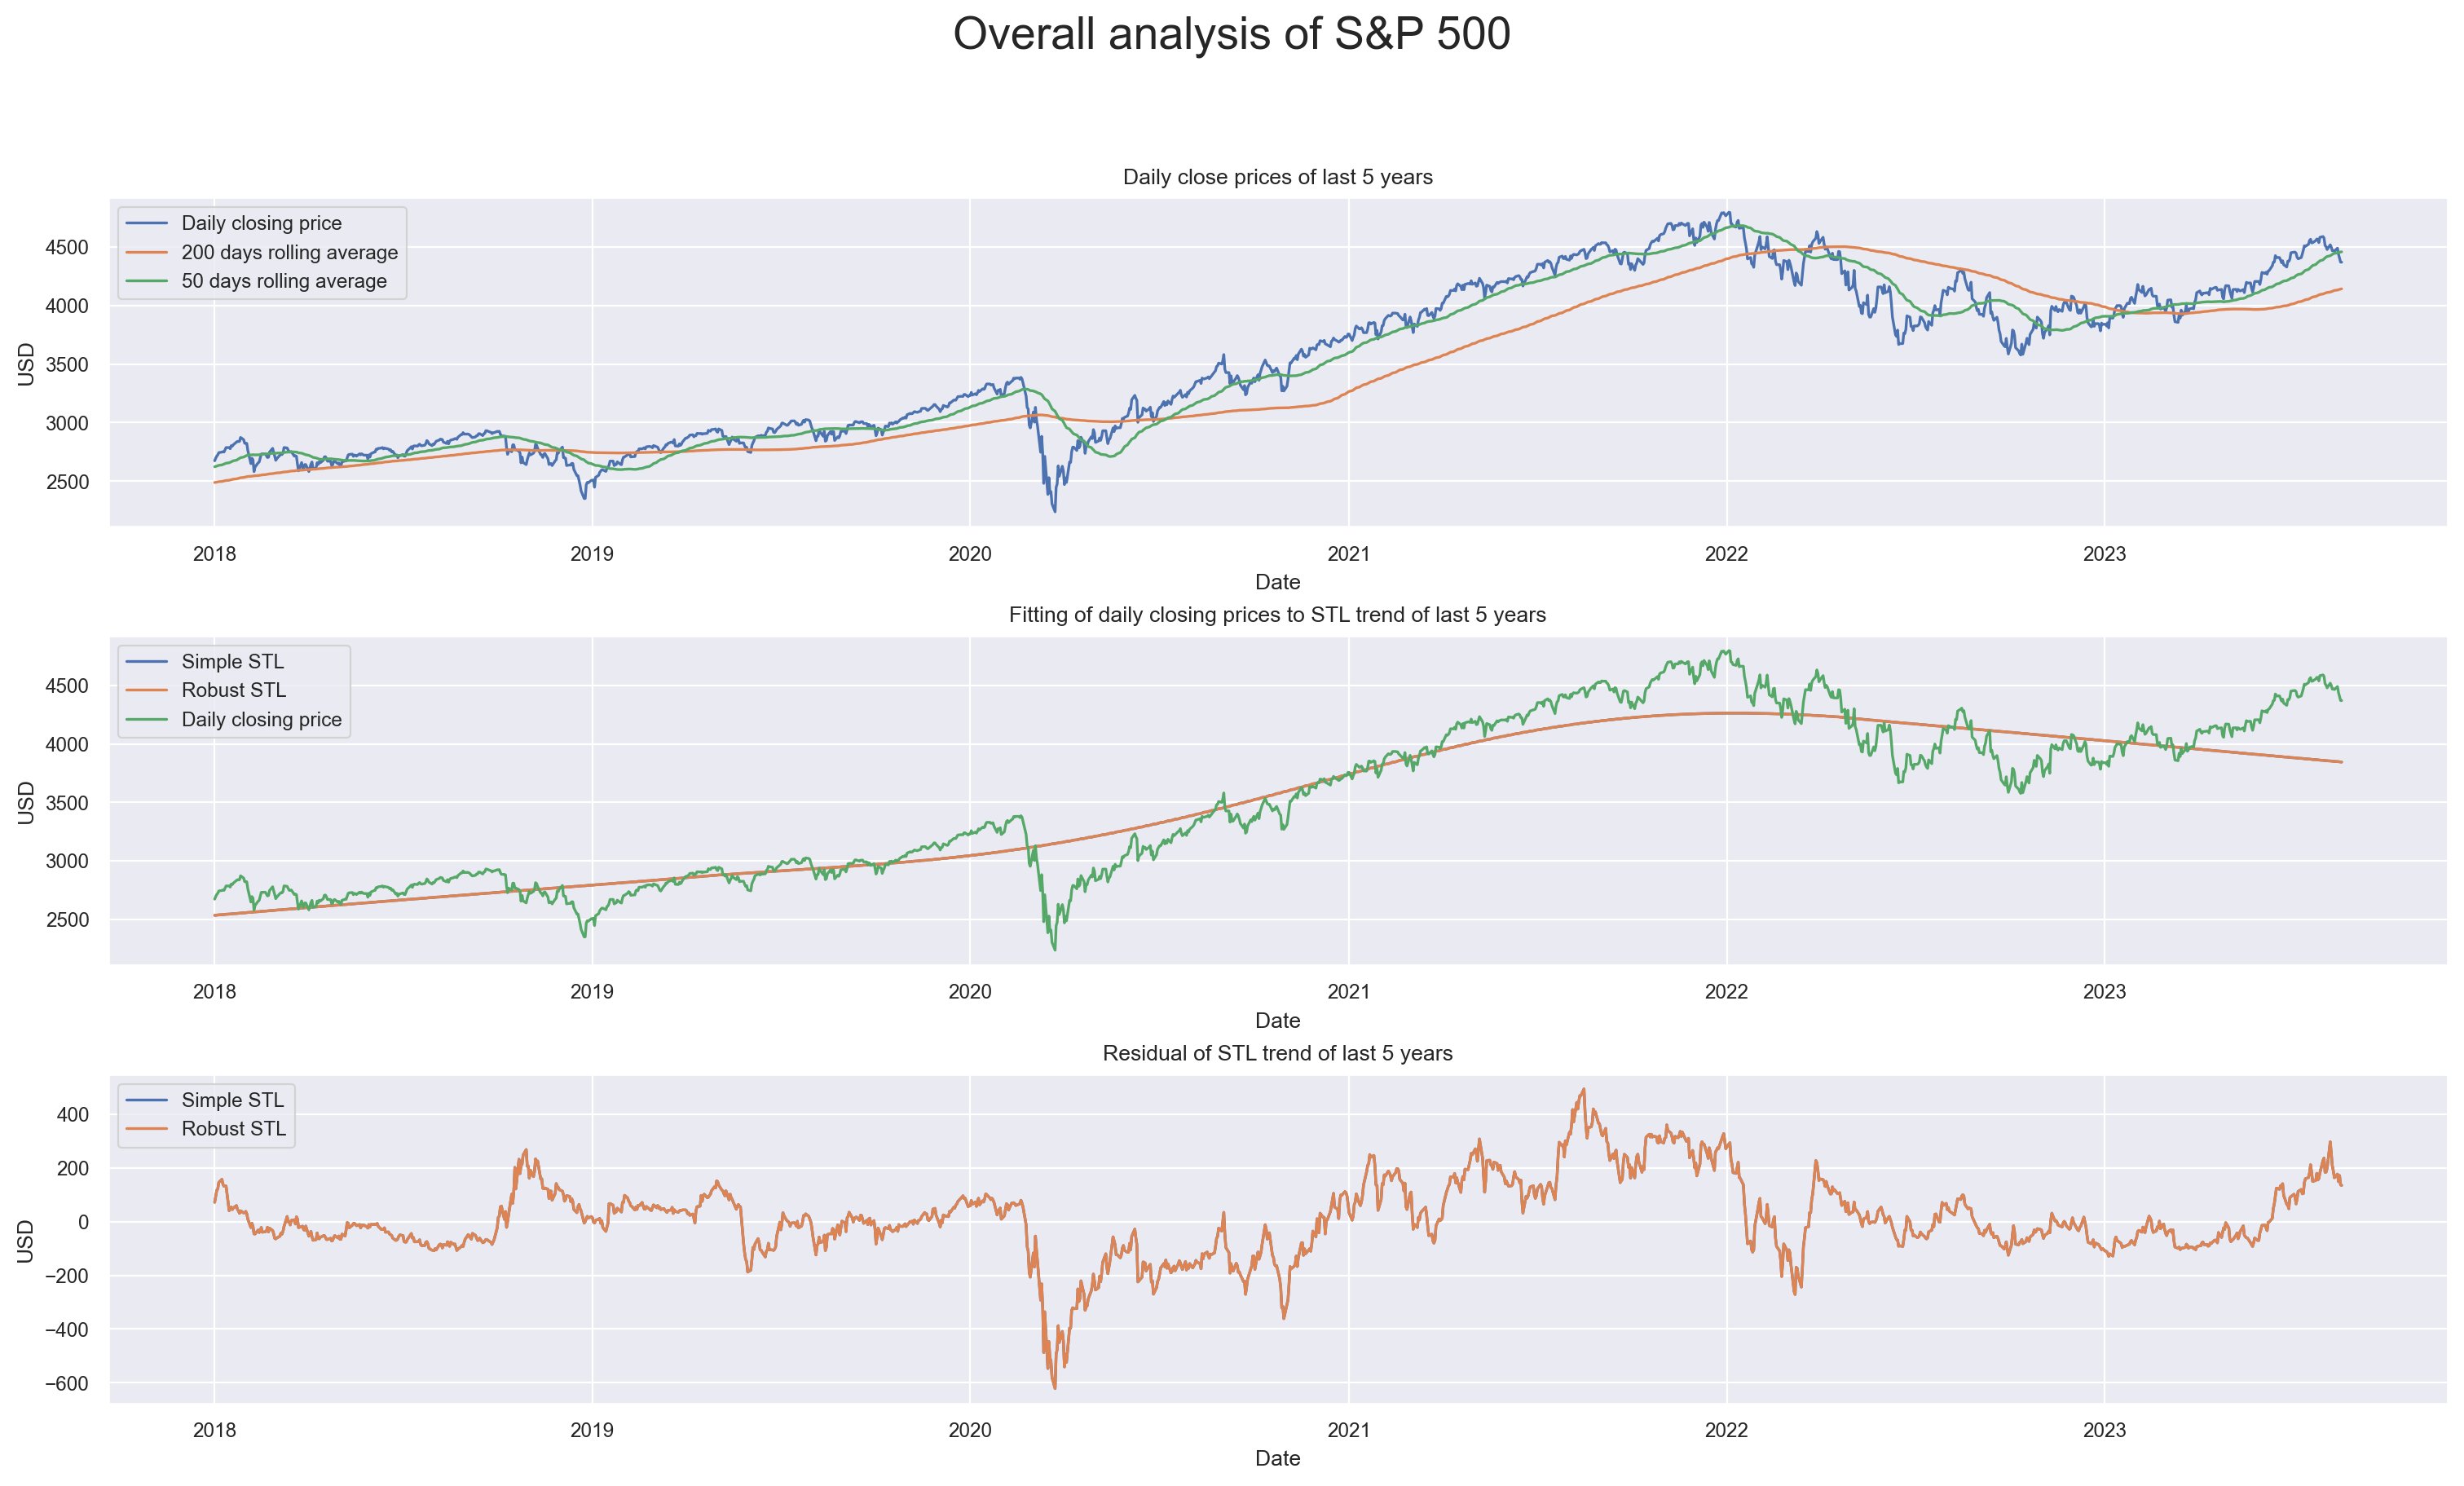

In [3]:

numSubPlots = 3
fig, axs = plt.subplots(numSubPlots, 1, figsize=(generalPlotWidth, generalSubPlotHight*numSubPlots), layout="constrained")
fig.suptitle(f'Overall analysis of {ticker.info["longName"]}\n\n', fontsize=20)

currentAxis = 0

# Plot overall closing prices of last x years
overallDf = pd.DataFrame(data=df)
overallDf[f'{rolling_wide_resolution} days rolling average'] = overallDf['Close'].rolling(rolling_wide_resolution).mean()
overallDf[f'{rolling_narrow_resolution} days rolling average'] = overallDf['Close'].rolling(rolling_narrow_resolution).mean()
overallDf.rename(columns={'Close':'Daily closing price'}, inplace=True)
overallDf = overallDf[rangeMax5yrs.min():pd.to_datetime('today')]
sns.lineplot(data=overallDf, dashes=False, ax=axs[currentAxis], legend='full')
axs[currentAxis].set_title(f'Daily close prices of last {rangeNumOfYears} years')
axs[currentAxis].set_ylabel(ticker.info['currency'])
currentAxis += 1


# Plot overall closing prices of last x years with STL trend
overallDf = pd.DataFrame(data=trendDecompDf)
overallDf = overallDf[rangeMax5yrs.min():pd.to_datetime('today')]
overallDf['Daily closing price'] = df[rangeMax5yrs.min():pd.to_datetime('today')]['Close']
sns.lineplot(data=overallDf, dashes=False, ax=axs[currentAxis], legend='full')
axs[currentAxis].set_title(f'Fitting of daily closing prices to STL trend of last {rangeNumOfYears} years')
axs[currentAxis].set_ylabel(ticker.info['currency'])
currentAxis += 1


# Plot overall STL residual of last x years with STL trend
overallDf = pd.DataFrame(data=residDecompDf)
sns.lineplot(data=overallDf[['Simple STL', 'Robust STL']], dashes=False, ax=axs[currentAxis], legend='full')
axs[currentAxis].set_title(f'Residual of STL trend of last {rangeNumOfYears} years')
axs[currentAxis].set_ylabel(ticker.info['currency'])
currentAxis += 1

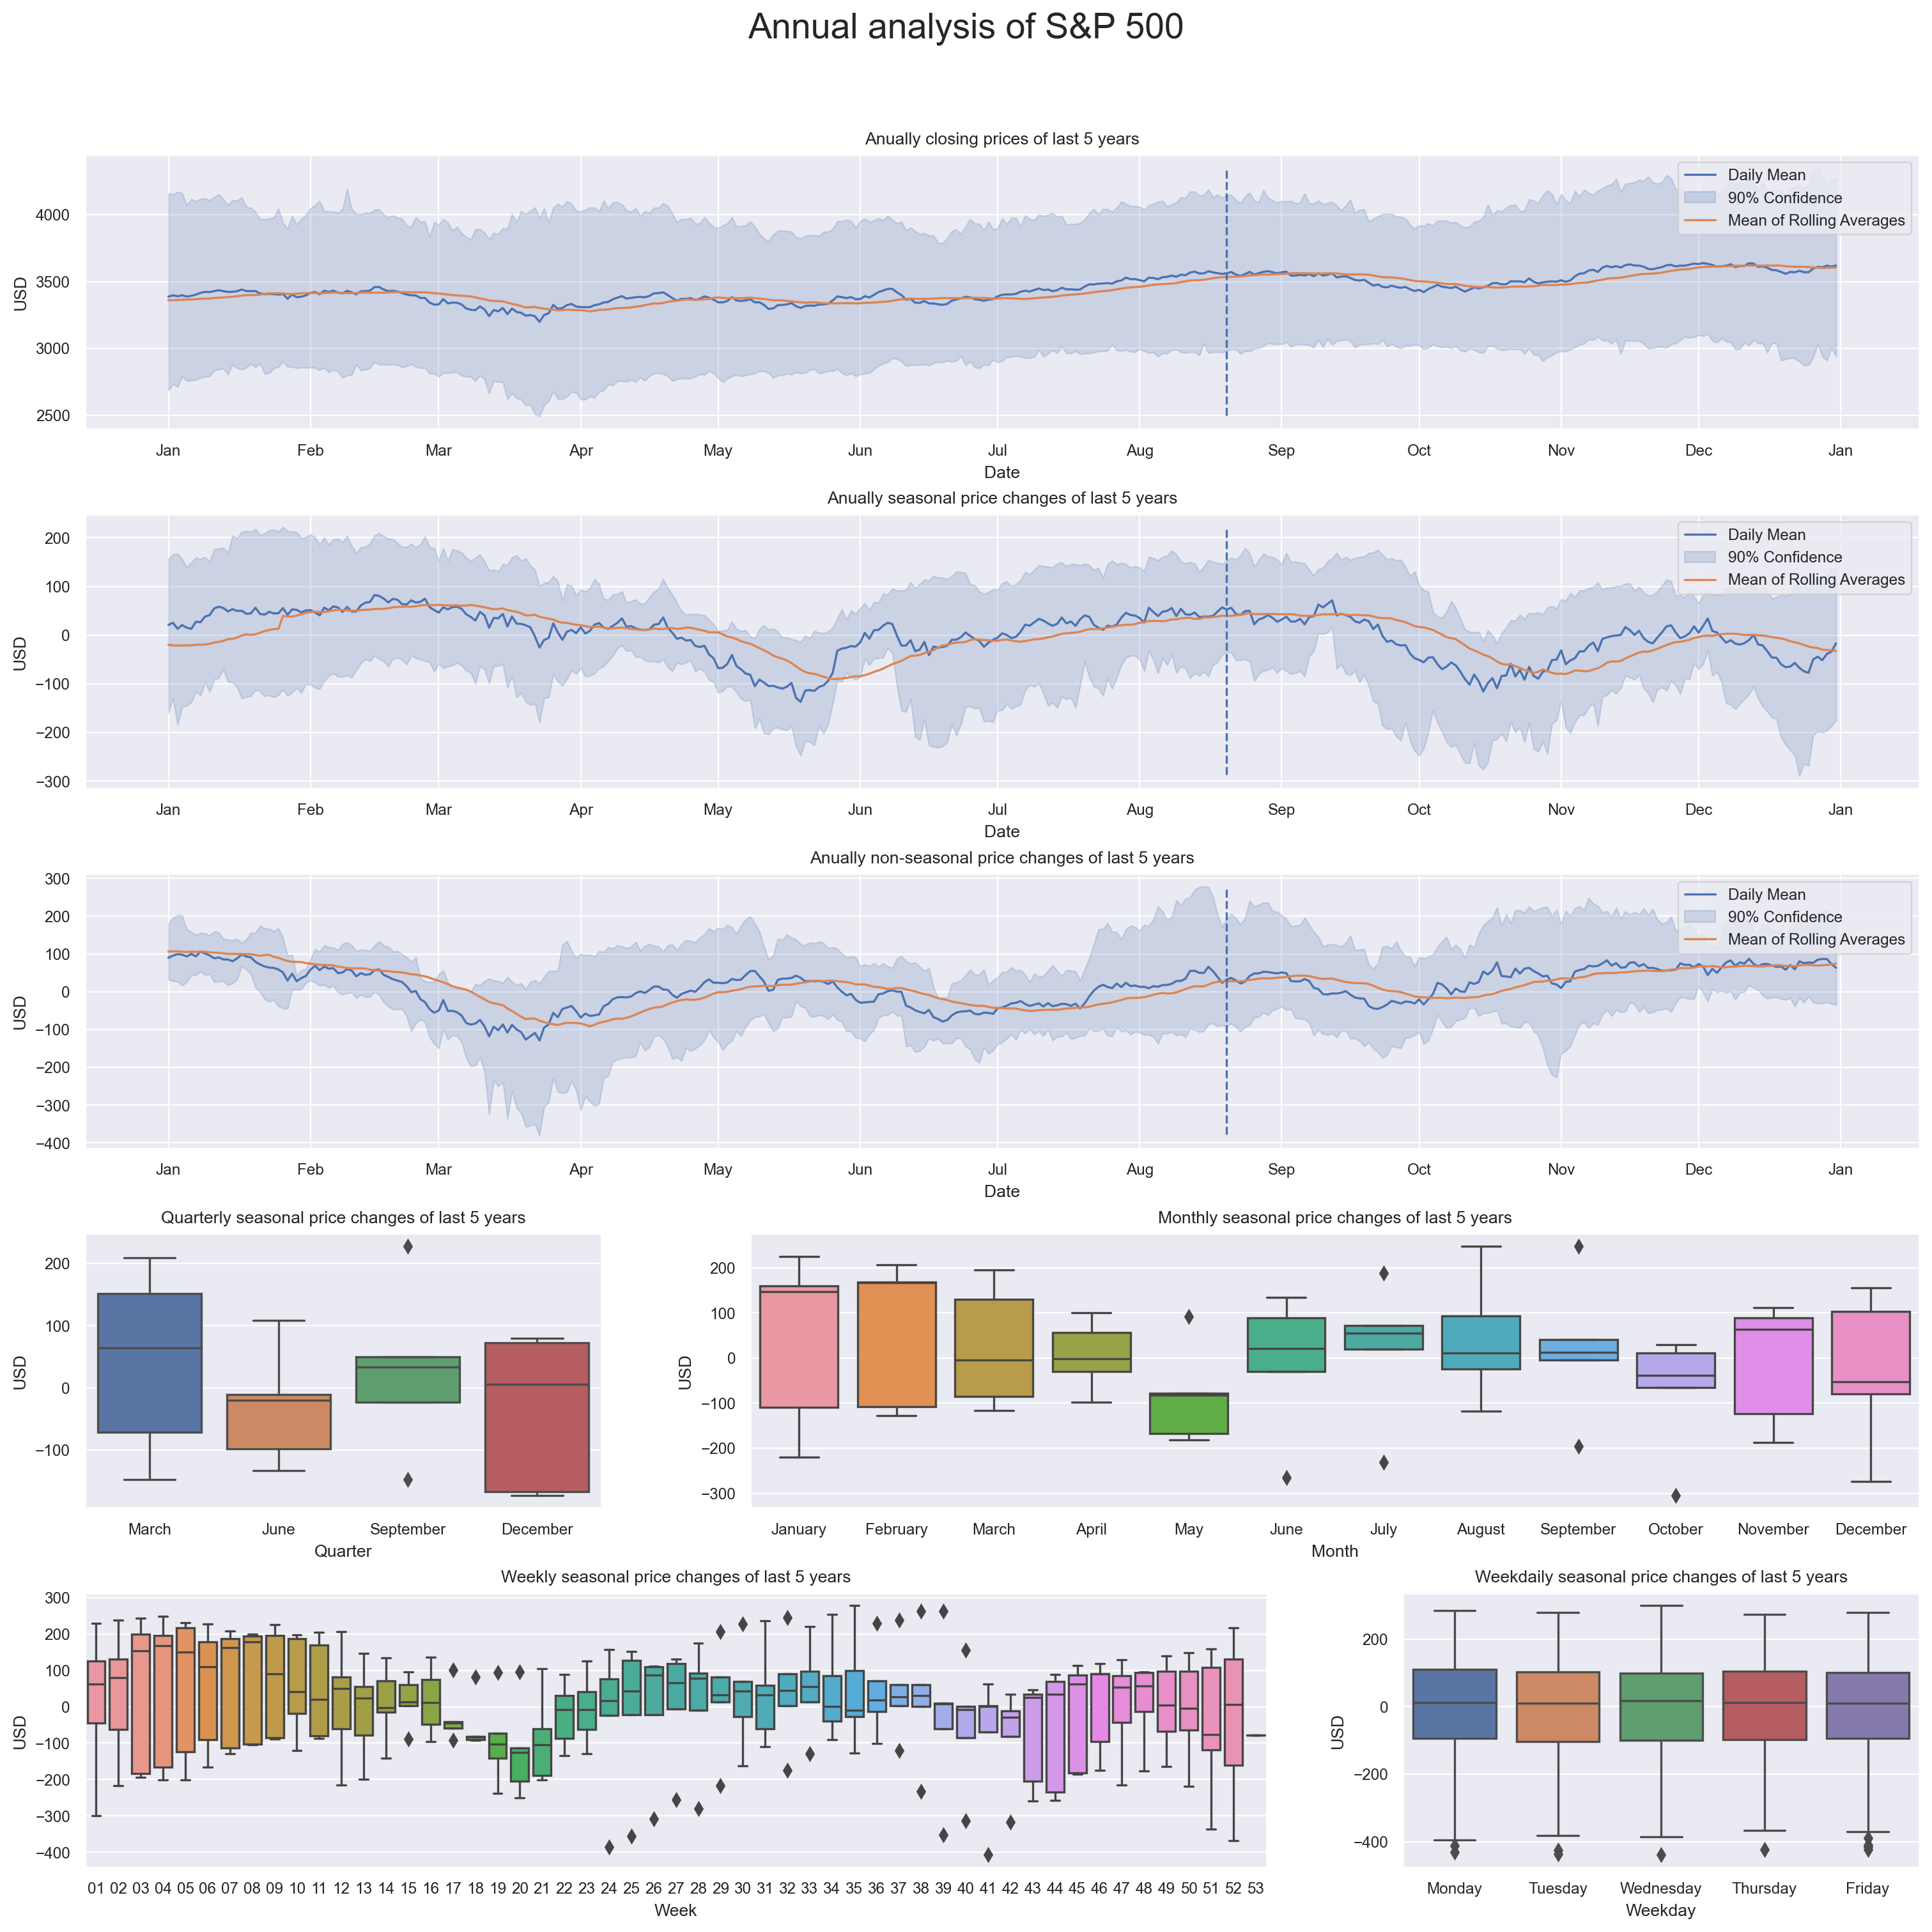

In [4]:
axs = []
numSubPlots = 5

fig = plt.figure(layout="constrained", figsize=(generalPlotWidth, generalSubPlotHight*numSubPlots))
gs = GridSpec(5, 3, figure=fig)
sns.set_theme('paper')
fig.suptitle(f'Annual analysis of {ticker.info["longName"]}\n\n', fontsize=20)

currentAxis = 0

axs.append(fig.add_subplot(gs[0, :]))   # add plot over full line
# Plot annual closing prices with confidence band
sns.lineplot(data=annualDf, x='Day', y='Close', ax=axs[currentAxis], sort=True)
sns.lineplot(data=annualDf, x='Day', y='rolling average', ax=axs[currentAxis], sort=True, errorbar=None)
axs[currentAxis].xaxis.set_major_locator(mdates.MonthLocator())
axs[currentAxis].axvline(f'{"{:02d}".format(dt.date.today().month)}-{"{:02d}".format(dt.date.today().day)}', ymin=0.05, ymax=0.95, linestyle='dashed')
axs[currentAxis].set_ylabel('USD')
axs[currentAxis].set_xlabel('Date')
axs[currentAxis].set_title(f'Anually closing prices of last {rangeNumOfYears} years')
axs[currentAxis].legend(labels=['Daily Mean', '90% Confidence', 'Mean of Rolling Averages'])
axs[currentAxis].xaxis.set_major_formatter(mdates.DateFormatter("%b"))
currentAxis += 1


axs.append(fig.add_subplot(gs[1, :]))   # add plot over full line
# Plot annual seasonal prices with confidence band
sns.lineplot(data=annunalSeasonalDecompDf, ax=axs[currentAxis], x='Day', y='Simple STL')
sns.lineplot(data=annunalSeasonalDecompDf, x='Day', y='rolling average', ax=axs[currentAxis], sort=True, errorbar=None)
axs[currentAxis].xaxis.set_major_locator(mdates.MonthLocator())
axs[currentAxis].axvline(f'{"{:02d}".format(dt.date.today().month)}-{"{:02d}".format(dt.date.today().day)}', ymin=0.05, ymax=0.95, linestyle='dashed')
axs[currentAxis].set_ylabel('USD')
axs[currentAxis].set_xlabel('Date')
axs[currentAxis].set_title(f'Anually seasonal price changes of last {rangeNumOfYears} years')
axs[currentAxis].legend(labels=['Daily Mean', '90% Confidence', 'Mean of Rolling Averages'])
axs[currentAxis].xaxis.set_major_formatter(mdates.DateFormatter("%b"))
currentAxis += 1


axs.append(fig.add_subplot(gs[2, :]))   # add plot over full line
# Plot annual residual prices with confidence band
sns.lineplot(data=annunalResidDecompDf, ax=axs[currentAxis], x='Day', y='Simple STL')
sns.lineplot(data=annunalResidDecompDf, x='Day', y='rolling average', ax=axs[currentAxis], sort=True, errorbar=None)
axs[currentAxis].xaxis.set_major_locator(mdates.MonthLocator())
axs[currentAxis].axvline(f'{"{:02d}".format(dt.date.today().month)}-{"{:02d}".format(dt.date.today().day)}', ymin=0.05, ymax=0.95, linestyle='dashed')
axs[currentAxis].set_ylabel('USD')
axs[currentAxis].set_xlabel('Date')
axs[currentAxis].set_title(f'Anually non-seasonal price changes of last {rangeNumOfYears} years')
axs[currentAxis].legend(labels=['Daily Mean', '90% Confidence', 'Mean of Rolling Averages'])
axs[currentAxis].xaxis.set_major_formatter(mdates.DateFormatter("%b"))
currentAxis += 1


axs.append(fig.add_subplot(gs[3, 0]))
# Plot quarterly seasonal prices
sns.boxplot(data=quarterlySeasonalDecompDf, x='Quarter', y='Simple STL', ax=axs[currentAxis])
axs[currentAxis].set_ylabel('USD')
axs[currentAxis].set_title(f'Quarterly seasonal price changes of last {rangeNumOfYears} years')
currentAxis += 1

axs.append(fig.add_subplot(gs[3, 1:]))
# Plot monthly seasonal prices
sns.boxplot(data=monthlySeasonalDecompDf, x='Month', y='Simple STL', ax=axs[currentAxis])
axs[currentAxis].set_ylabel('USD')
axs[currentAxis].set_title(f'Monthly seasonal price changes of last {rangeNumOfYears} years')
currentAxis += 1

axs.append(fig.add_subplot(gs[4, :-1]))
# Plot weekly seasonal prices
sns.boxplot(data=weeklySeasonalDecompDf, x='Week', y='Simple STL', ax=axs[currentAxis])
axs[currentAxis].set_ylabel('USD')
axs[currentAxis].set_title(f'Weekly seasonal price changes of last {rangeNumOfYears} years')
currentAxis += 1

axs.append(fig.add_subplot(gs[4, 2]))
# Plot weekdaily seasonal prices
sns.boxplot(data=weekdailySeasonalDecompDf, x='Weekday', y='Simple STL', ax=axs[currentAxis])
axs[currentAxis].set_ylabel('USD')
axs[currentAxis].set_title(f'Weekdaily seasonal price changes of last {rangeNumOfYears} years')
currentAxis += 1
